In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

2025-09-06 01:52:23.219033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757123543.434709      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757123543.496704      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


- IMDB(Internet Movie Data Base)
- IMDB 구성 : Train Data(25000개중 긍정 12500개, 부정 12500개), Test Data(25000개 중 긍정 12500개, 부정 12500개)
- NLP : Natural Language Processing(자연어 처리)
- 말뭉치 : 하나의 데이터셋
- 토큰 : 하나의 단어
- 어휘사전 : 번호로 구분된 유일한 단어들의 집단
- 머신러닝이나 딥러닝에서는 데이터가 숫자로 구성되어 있어야 함으로 이런 단어들을 고유한 번호로 할당하여 사용한다. 

### imdb 데이터 로드 및 전처리

In [2]:
# imdb 데이터 로드 (500개의 단어만 사용)
num_words = 500
(train_input, train_target), (test_input, test_target) = \
                                imdb.load_data(num_words=num_words)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
# train과 test의 크기
print(len(train_input), len(test_input))

25000 25000


In [4]:
# train의 첫번째 문장의 Token 갯수
len(train_input[0])

218

In [5]:
# train의 두번째 문장의 Token 갯수
len(train_input[1])

189

> 영화의 댓글 길이가 다름

In [10]:
# 첫번째 댓글의 출력
print(train_input[3])

[1, 4, 2, 2, 33, 2, 4, 2, 432, 111, 153, 103, 4, 2, 13, 70, 131, 67, 11, 61, 2, 2, 35, 2, 2, 61, 2, 452, 2, 4, 2, 7, 2, 59, 166, 4, 105, 216, 2, 41, 2, 9, 15, 7, 35, 2, 2, 31, 8, 4, 2, 23, 4, 2, 2, 6, 2, 42, 38, 39, 121, 59, 456, 10, 10, 7, 265, 12, 2, 111, 153, 159, 59, 16, 2, 21, 25, 2, 482, 39, 4, 96, 59, 2, 12, 4, 172, 65, 9, 2, 11, 2, 4, 2, 5, 2, 7, 2, 17, 13, 2, 12, 19, 6, 464, 31, 314, 11, 2, 6, 2, 2, 11, 8, 202, 27, 310, 4, 2, 2, 8, 2, 58, 10, 10, 2, 2, 180, 40, 14, 413, 173, 7, 263, 112, 37, 152, 377, 4, 2, 263, 2, 2, 178, 54, 75, 71, 476, 36, 413, 263, 2, 182, 5, 17, 75, 2, 2, 36, 279, 131, 2, 17, 2, 42, 17, 35, 2, 2, 192, 5, 2, 2, 19, 2, 217, 2, 2, 2, 2, 2, 5, 2, 10, 10, 61, 403, 9, 2, 40, 61, 2, 5, 27, 2, 159, 90, 263, 2, 2, 309, 8, 178, 5, 82, 2, 4, 65, 15, 2, 145, 143, 2, 12, 2, 2, 2, 2, 2, 15, 2, 4, 2, 2, 7, 2, 94, 2, 2, 2, 11, 2, 4, 2, 7, 2, 246, 2, 9, 2, 11, 2, 14, 9, 51, 408, 12, 94, 318, 2, 12, 47, 6, 2, 2, 5, 2, 2, 19, 49, 7, 4, 2, 2, 2, 25, 80, 126, 2, 10, 10, 2, 2

- Sample의 시작 부분의 토큰은 1을 사용한다.
- 2는 선정한 단어갯수에 포함되지 않은 단어를 표현한다.

In [7]:
# train target의 출력
print(train_target[:10])

[1 0 0 1 0 0 1 0 1 0]


### 훈련 세트의 준비

In [11]:
train_input, val_input, train_target, val_target = \
                        train_test_split(
                            train_input,
                            train_target,
                            test_size=0.2,
                            random_state=42
                        )

In [15]:
# train_input의 Token 길이 
lengths = np.array([len(x) for x in train_input])
print(f"평균길이 : {np.mean(lengths)}, 중앙값 길이 : {np.median(lengths)}")

평균길이 : 239.00925, 중앙값 길이 : 178.0


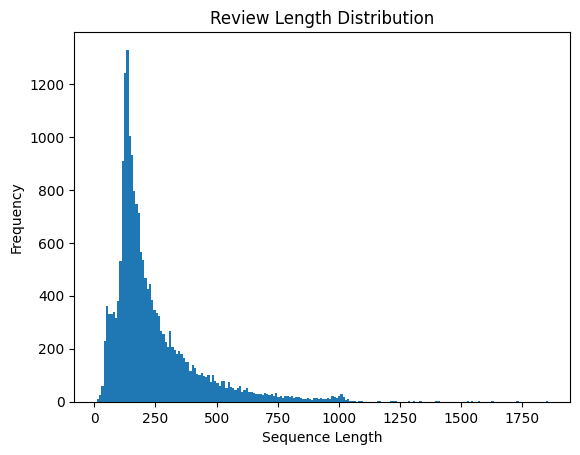

In [18]:
# 시각화 : 댓글 길이에 대한 빈도수 
plt.hist(lengths, bins=200)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Review Length Distribution")
plt.show()

---
### Sequence Padding 
: 전체 자릿수를 100으로 가정했을 경우 예를 들어 한 문장에 3개의 토큰만 있으면 나머지 97개는 비워지고 이를 0으로 채우는 과정 

In [19]:
# 패딩 처리 (최대 길이 100)
max_len = 100
train_seq = pad_sequences(train_input, maxlen=max_len)
val_seq = pad_sequences(val_input, maxlen=max_len)
print(train_seq.shape)
print(val_seq.shape)

(20000, 100)
(5000, 100)


> 훈련과 검증은 20000개와 5000개로 나뉘었고 Feature의 크기는 100으로 고정됨

In [20]:
# 첫번째 댓글 확인
print(train_seq[0])

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


In [21]:
# 원본의 첫번째 댓글
print(train_input[0])

[1, 73, 89, 81, 25, 60, 2, 6, 20, 141, 17, 14, 31, 127, 12, 60, 28, 2, 2, 66, 45, 6, 20, 15, 497, 8, 79, 17, 491, 8, 112, 6, 2, 20, 17, 2, 2, 4, 436, 20, 9, 2, 6, 2, 7, 493, 2, 6, 185, 250, 24, 55, 2, 5, 23, 350, 7, 15, 82, 24, 15, 2, 66, 10, 10, 45, 2, 15, 4, 20, 2, 8, 30, 17, 2, 5, 2, 17, 2, 190, 4, 20, 9, 43, 32, 99, 2, 18, 15, 8, 157, 46, 17, 2, 4, 2, 5, 2, 9, 32, 2, 5, 2, 267, 17, 73, 17, 2, 36, 26, 400, 43, 2, 83, 4, 2, 247, 74, 83, 4, 250, 2, 82, 4, 96, 4, 250, 2, 8, 32, 4, 2, 9, 184, 2, 13, 384, 48, 14, 16, 147, 2, 59, 62, 69, 2, 12, 46, 50, 9, 53, 2, 74, 2, 11, 14, 31, 151, 10, 10, 4, 20, 9, 2, 364, 352, 5, 45, 6, 2, 2, 33, 269, 8, 2, 142, 2, 5, 2, 17, 73, 17, 204, 5, 2, 19, 55, 2, 2, 92, 66, 104, 14, 20, 93, 76, 2, 151, 33, 4, 58, 12, 188, 2, 151, 12, 215, 69, 224, 142, 73, 237, 6, 2, 7, 2, 2, 188, 2, 103, 14, 31, 10, 10, 451, 7, 2, 5, 2, 80, 91, 2, 30, 2, 34, 14, 20, 151, 50, 26, 131, 49, 2, 84, 46, 50, 37, 80, 79, 6, 2, 46, 7, 14, 20, 10, 10, 470, 158]


In [22]:
# 6번째의 댓글 확인
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


### PyTorch 데이터셋 및 데이터 로더 생성

In [23]:
# PyTorch Tensor 변환
train_seq_tensor = torch.tensor(train_seq, dtype=torch.long) # <<<<<
train_target_tensor = torch.tensor(train_target, dtype=torch.float32) # <<<<

val_seq_tensor = torch.tensor(val_seq, dtype=torch.long) # <<<<<
val_target_tensor = torch.tensor(val_target, dtype=torch.float32) # <<<<

In [24]:
train_seq_tensor[0]

tensor([ 10,   4,  20,   9,   2, 364, 352,   5,  45,   6,   2,   2,  33, 269,
          8,   2, 142,   2,   5,   2,  17,  73,  17, 204,   5,   2,  19,  55,
          2,   2,  92,  66, 104,  14,  20,  93,  76,   2, 151,  33,   4,  58,
         12, 188,   2, 151,  12, 215,  69, 224, 142,  73, 237,   6,   2,   7,
          2,   2, 188,   2, 103,  14,  31,  10,  10, 451,   7,   2,   5,   2,
         80,  91,   2,  30,   2,  34,  14,  20, 151,  50,  26, 131,  49,   2,
         84,  46,  50,  37,  80,  79,   6,   2,  46,   7,  14,  20,  10,  10,
        470, 158])

In [25]:
train_target_tensor[:10]

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [26]:
# PyTorch Dataset 및 DataLoader 생성
batch_size = 64 # mini batch
train_dataset = TensorDataset(train_seq_tensor, train_target_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_seq_tensor, val_target_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### RNN Model

In [39]:
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SimpleRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x) # 임베딩 수행 
        output, hidden = self.rnn(embedded) 
        return self.sigmoid(self.fc(hidden.squeeze(0))) 

- hidden_dim : RNN에서 사용하는 뉴런의 갯수 (Hyper parameter)
- embedded_dim : 토큰 갯수 

In [40]:
# 모델 파라미터 설정
vocab_size = num_words
embedding_dim = 50
hidden_dim = 8
output_dim = 1 

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [42]:
model = SimpleRNN(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)
model


SimpleRNN(
  (embedding): Embedding(500, 50)
  (rnn): RNN(50, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [43]:
# 손실함수와 옵티마이저
criterion = nn.BCELoss() # Binary Cross Entropy
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)

In [44]:
# 학습 함수 정의
def train(model, train_loader, criterion, optimizer, device):
    model.train() # 뉴런들이 훈련모드로 동작하도록 설정 
    epoch_loss = 0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad() # 이전 반복에서 계산된 그래디언트를 초기화 
        predictions = model(inputs).squeeze(1) # 예측값
        loss = criterion(predictions, targets) # 모델의 예측값과 실제 타겟 간의 손실을 계산 
        loss.backward() # 손실에 대한 그래디언트를 계산하고 역전파 
        optimizer.step() # 계산된 그래디언트를 사용하고 모델의 파라미터를 업데이트 

        epoch_loss += loss.item()
        correct += ((predictions >= 0.5).float() == targets).sum().item()
        total += targets.size(0)
        
    accuracy = correct / total
    return epoch_loss / len(train_loader), accuracy

In [45]:
# 평가함수 
def evaluate(model, val_loader, criterion, device):
    model.eval() # 평가모드로 동작하도록 설정 
    epoch_loss = 0 # 전체 손실 합계 
    correct = 0 # 정확하게 예측한 샘플 수 
    total = 0 # 전체 샘플 수
    with torch.no_grad() : # 평가 중에는 그래디언트 계산이 필요 없으므로 메모리 사용량 및 연산 속도 향상
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            predictions = model(inputs).squeeze(1) # 예측값 발생 
            loss = criterion(predictions, targets) # 손실계산
            
            epoch_loss += loss.item() # 전체 손실에 더하기 
            correct += ((predictions >= 0.5).float() == targets).sum().item()
            total += targets.size(0)

        accuracy = correct / total
        return epoch_loss/len(val_loader), accuracy # 평균손실과 정확도 

In [ ]:
# 모델 학습 실행
num_epochs = 100

best_val_loss = float('inf') # 가장 큰 값 정의 

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f"Epoch : {epoch+1}/{num_epochs}")
    print(f"- Train Loss : {train_loss:.4f} | Train Accuracy : {train_acc:.2%}")
    print(f"- Val   Loss : {val_loss:.4f} | Val   Accuracy : {val_acc:.2%}")

    # 모델 저장 (Callbacks)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_rnn_model.pth')

Epoch : 1/100
- Train Loss : 0.7098 | Train Accuracy : 51.32%
- Val   Loss : 0.7000 | Val   Accuracy : 51.54%
Epoch : 2/100
- Train Loss : 0.6983 | Train Accuracy : 51.92%
- Val   Loss : 0.6957 | Val   Accuracy : 52.48%
Epoch : 3/100
- Train Loss : 0.6949 | Train Accuracy : 51.99%
- Val   Loss : 0.6935 | Val   Accuracy : 52.66%
Epoch : 4/100
- Train Loss : 0.6924 | Train Accuracy : 52.43%
- Val   Loss : 0.6918 | Val   Accuracy : 53.12%
Epoch : 5/100
- Train Loss : 0.6904 | Train Accuracy : 52.91%
- Val   Loss : 0.6902 | Val   Accuracy : 54.10%
Epoch : 6/100
- Train Loss : 0.6887 | Train Accuracy : 53.41%
- Val   Loss : 0.6889 | Val   Accuracy : 54.16%
Epoch : 7/100
- Train Loss : 0.6871 | Train Accuracy : 54.02%
- Val   Loss : 0.6880 | Val   Accuracy : 53.80%
Epoch : 8/100
- Train Loss : 0.6857 | Train Accuracy : 54.22%
- Val   Loss : 0.6867 | Val   Accuracy : 54.76%
Epoch : 9/100
- Train Loss : 0.6843 | Train Accuracy : 54.94%
- Val   Loss : 0.6859 | Val   Accuracy : 54.84%
Epoch : 10